In [49]:
import string
import gensim
import pymorphy2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models
from gensim.models import CoherenceModel

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Data

### Downloading

In [3]:
groups = pd.read_csv('data/groups.csv', low_memory=False)
posts = pd.read_csv('data/posts.csv', low_memory=False)

groups = groups.drop(columns=['Unnamed: 0'])
posts = posts.drop(columns=['Unnamed: 0'])

posts = posts.dropna()

#### Users list

In [ ]:
users = set(posts['owner_id'])
users = list(filter(lambda user: type(user) == str, users))
len(users)

### Get reposts

In [1]:
from vk import VkAPI

In [2]:
vk = VkAPI()

In [ ]:
reposts = {}

for user in users:
    reposts.update({user: []})
    try:
        vk_posts = vk.get_user_posts(user)['items']
        user_posts = list(notna_posts['post_id'].loc[notna_posts['owner_id'] == user].values)
        vk_posts = [post for post in vk_posts if str(post['id']) in user_posts]
        for post in vk_posts:
            if 'copy_history' in post:
                for repost in post['copy_history']:
                    reposts[user].append((str(post['id']), repost['text']))
    except:
        print(user)
    with open('reposts.txt', 'a') as file:
        file.write(f'{user}: {str(reposts[user])}\n')

In [128]:
not_empty_reposts = {user: reposts_posts for user, reposts_posts in reposts.items() if len(reposts_posts) > 0}

reposts_users = []
reposts_data = []

for user, posts in not_empty_reposts.items():
    for p in posts:
        reposts_users.append(str(user))
        reposts_data.append(p)

        
df_reposts = pd.DataFrame()
df_reposts['owner_id'] = reposts_users
df_reposts['post_id'] = reposts_data

In [129]:
df_reposts

,owner_id,post_id
0,170371253,1617
1,170371253,1607
2,286872155,1686
3,286872155,1683
4,540904,6196
...,...,...
8710,9246170,7298
8711,210478,17801
8712,210478,17798
8713,210478,17787


In [130]:
df_only_reposts = df_reposts.merge(posts, on=['post_id', 'owner_id'], how='left')

In [131]:
df_only_reposts = df_only_reposts.drop(columns=['post_id'])

,owner_id,post_id,date,text,comments,likes,reposts,views
0,170371253,1617,1623181785,😂😂😂😂😂😂😂😂,0,0,0,154
1,170371253,1607,1597865564,😂😂😂,0,2,0,183
2,286872155,1686,1620420072,Я тут!!!,0,0,0,73
3,286872155,1683,1619715801,❤️❤️❤️🎉🎉🎉,0,0,0,59
4,540904,6196,1622276003,Бляяя😕 Какой бред😠 Начинается всё то-же самое ...,0,3,2,149
...,...,...,...,...,...,...,...,...
8710,9246170,7298,1622424213,Собаку хочу,0,0,0,86
8711,210478,17801,1622114182,УХ КРАСОТА!!!,0,2,0,127
8712,210478,17798,1620668314,отлично посидели на Ладоге!,0,7,1,137
8713,210478,17787,1614612365,Ура!!! Мы это сделали! Моя маленькая-большая п...,0,4,0,150


## Analysis of texts containing only nouns

In [125]:
processed_nouns_reposts = pd.read_csv('data/processed/bspb_reposts_nouns.csv')
processed_nouns_posts = pd.read_csv('data/processed/bspb_posts_nouns.csv')

In [154]:
processed_nouns_reposts

,Unnamed: 0,owner_id,post_id,text,clear_text,nouns
0,0,273694109,826,РОССИЯ: ОСТАНОВИТЬ ЗАКОНОПРОЕКТ О ПРИНУДИТЕЛЬН...,россия останавливать законопроект принудительн...,россия законопроект вакцинация ноябрь гос дума...
1,1,116524602,10482,Спиcoк caмых эффeктивных лeкaрcтв нa рaзныe cл...,список самый эффективный лекарство разный случ...,список лекарство случай жизнь
2,2,15835662,1127,"Кому меда? еще остался, прямиком из Тайги.\nЗа...",мед оставаться прямиком тайга качество ручатьс...,мед тайга качество личка
3,3,31868444,6676,22 МАЯ | 20:00\nТанцевальный спектакль «плач/ь...,май танцевальный спектакль плач ь билет dancek...,май спектакль плач билет счастие счастие свобо...
4,4,31868444,6673,"Сегодня день рождения [id31868444|Даши], нашег...",сегодня день рождение даша наш фитнес тренер д...,день рождение даша фитнес тренер растяжка утро...
...,...,...,...,...,...,...
6390,6390,554424,5189,Давайте спасать планету!,давать спасать планета,планета
6393,6393,1824199,3202,Подарочный сертификат🏃‍🏃‍🏃‍\n\n22 декабря – ка...,подарочный сертификат __u0001f3c3__ __u0001f3c...,сертификат декабрь катастрофа город сувенир па...
6394,6394,267284787,396,Учись студент,учиться студент,студент
6395,6395,17665225,1333,Беда не приходит одна 😆,беда приходить __u0001f606__,беда


In [140]:
processed_nouns_posts

,Unnamed: 0,from_id,post_id,text,clear_text,nouns
1,1,145,2292,"Сколько же всего изменилось за это время, 7 ле...",сколько изменяться время год проходить рождать...,время год сын бизнес вещь челси сердце клуб иг...
2,2,145,2292,"Жаль, что из-за политики Абрамовича клуб так и...",жаль политика абрамович клуб начинать играть с...,политика абрамович клуб надежда челси слава
3,3,145,2290,Полтора года назад искал решение некоторых сво...,полтора год назад искать решение некоторый сво...,год решение проблема простор интернет виктор п...
4,4,145,2290,На данный момент дружим семьями и безумно благ...,данный момент дружить семья безумно благодарны...,момент семья судьба человек
5,5,145,2290,К сожалению не имею возможности поздравить лич...,сожаление иметь возможность поздравлять лично ...,сожаление возможность год жизнь ребенок успех
...,...,...,...,...,...,...
810835,810835,619951213,49,она вместит себе в глотку револьвер,вмещать глотка револьвер,глотка револьвер
810836,810836,619951213,47,огонь да мясо,огонь мясо,огонь мясо
810837,810837,619951213,35,Твой аромат.,твой аромат,аромат
810838,810838,620178523,449,Вводи код 6s2jq8 и получай 5 руб!,вводить код получать руб,код руб


In [137]:
processed_nouns_reposts = processed_nouns_reposts.loc[processed_nouns_reposts['nouns'].notna()]

In [139]:
processed_nouns_posts = processed_nouns_posts.loc[processed_nouns_posts['nouns'].notna()]

In [141]:
combined_nouns_df = pd.concat([processed_nouns_reposts['nouns'], 
                         processed_nouns_posts['nouns']])

In [142]:
texts_nouns_list = [str(values).split() for values in combined_nouns_df]

In [143]:
id2word = corpora.Dictionary(texts_nouns_list)

In [144]:
corpus = []
for text in texts_list:
    corpus.append(id2word.doc2bow(text))

In [145]:
perplexity_nouns_metrics = []
coherence_nouns_metrics = []
    
for topic_n in range(4,15):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=topic_n, 
                                            random_state=42,
                                            update_every=1,
                                            chunksize=5000,
                                            passes=10,
                                            iterations=10,
                                            alpha='auto',
                                            per_word_topics=True)
    
    perplexity_nouns_metrics = lda_model.log_perplexity(corpus)
    perplexity_nouns_metrics.append(perplexity)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts_nouns_list, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_nouns_metrics.append(coherence_lda)

    lda_model.save(f'lda_model_posts_reposts_nouns_notna_{topic_n}.model')
    print(topic_n)

4
5
6
7
8
9
10
11
12
13
14


## Perplexity

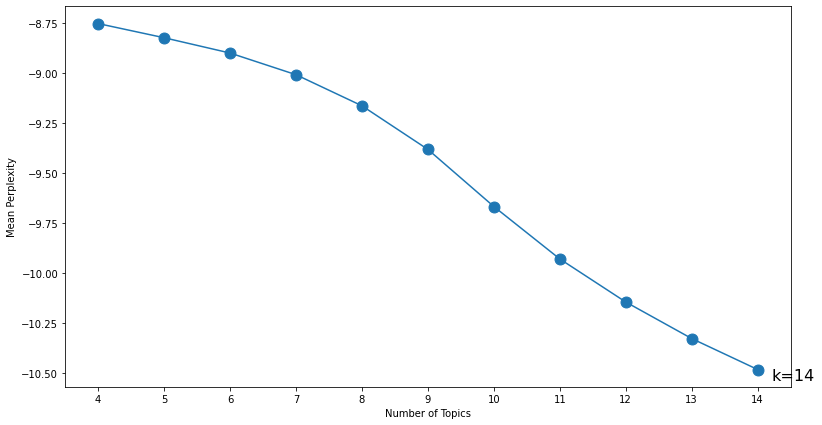

In [146]:
fig = plt.figure(figsize=(13,7))

ax = plt.plot(list(range(4,15)), perplexity_nouns_metrics)

plt.xticks(list(range(4,15)))
plt.xlabel("Number of Topics")
plt.ylabel("Mean Perplexity")

plt.scatter(list(range(4,15)), perplexity_nouns_metrics, s=120)

ymax = min(perplexity_nouns_metrics)
xpos = perplexity_nouns_metrics.index(ymax)
best_k = list(range(4,15))[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

plt.show()

## Coherence

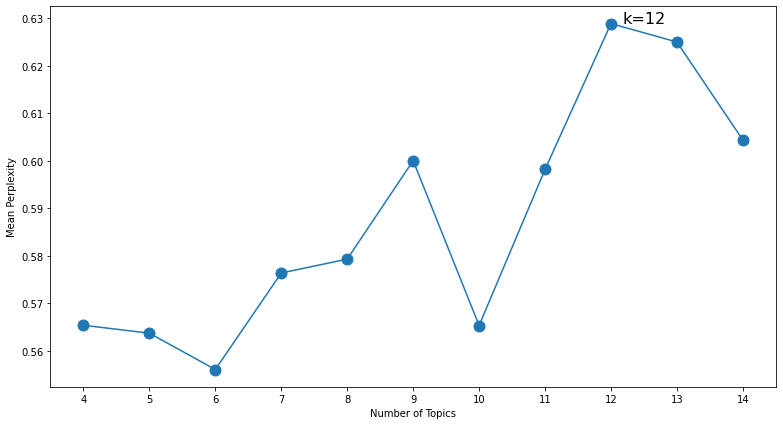

In [147]:
fig = plt.figure(figsize=(13,7))

ax = plt.plot(list(range(4,15)), coherence_nouns_metrics)

plt.xticks(list(range(4,15)))
plt.xlabel("Number of Topics")
plt.ylabel("Mean Perplexity")

plt.scatter(list(range(4,15)), coherence_nouns_metrics, s=120)

ymax = max(coherence_nouns_metrics)
xpos = coherence_nouns_metrics.index(ymax)
best_k = list(range(4,15))[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

plt.show()

The best result with topics number = 12

## Visualization

In [150]:
lda_model_12_topics = gensim.models.ldamodel.LdaModel.load('lda_model_posts_reposts_nouns_notna_12.model')

In [151]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_12_topics, corpus, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.218995  0.389438       1        1  10.445425
8      0.051847  0.473442       2        1  10.371773
11     0.465814 -0.009145       3        1   9.753213
5     -0.427228 -0.089627       4        1   9.191854
10     0.162397  0.153241       5        1   9.107170
2     -0.109641 -0.010124       6        1   8.130350
9     -0.319515 -0.337846       7        1   8.057522
3     -0.064194 -0.441999       8        1   8.055269
7     -0.419585  0.195414       9        1   7.690665
0      0.163973 -0.373594      10        1   7.113765
4      0.357966 -0.249943      11        1   6.882634
1      0.357161  0.300742      12        1   5.200359, topic_info=          Term          Freq         Total Category  logprob  loglift
7          год  38784.000000  38784.000000  Default  30.0000  30.0000
94        день  37674.000000  37674.000000  Default  29.0000  29.0000
64     человек  27573.000000  27573.000000  Default  28.0000  28.0000
66       жизнь  23782.000000  23782.000000  Default  27.0000  27.0000
5        время  20838.000000  20838.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
2136    сектор    864.124236    865.217483  Topic12  -5.0959   2.9552
5219     дочка    848.676466    849.769621  Topic12  -5.1140   2.9552
3234    турнир    846.093347    847.186506  Topic12  -5.1170   2.9552
5280     салат    839.711767    840.804924  Topic12  -5.1246   2.9551
2258  разговор    823.084085    824.177240  Topic12  -5.1446   2.9551

[401 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1247     12  0.998942     август
460      10  0.999129      автор
585       8  0.999699      акция
306      10  0.999528  александр
1032      7  0.999463     альбом
...     ...       ...        ...
278       5  0.999576     эмоция
103       5  0.999667    энергия
201       4  0.999609       этаж
1966      9  0.999525       язык
65        9  0.999492     январь

[382 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 9, 12, 6, 11, 3, 10, 4, 8, 1, 5, 2])

In [153]:
vis.token_table.to_csv('posts_reposts_topics.csv')